In [91]:
import icon_registration.data as data
import icon_registration.networks as networks
import icon_registration.network_wrappers as network_wrappers
import icon_registration.visualize as visualize
import icon_registration.train as train
import icon_registration.config as config
import icon_registration.inverseConsistentNet as inverseConsistentNet
from icon_registration.mermaidlite import compute_warped_image_multiNC
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import os
import pickle
from IPython.display import Image, display
import torch.nn.functional as F
import icon_registration as icon

def show(t):
    plt.imshow(t.cpu().detach())
    plt.colorbar()
    plt.show()

In [492]:
from icon_registration.losses import gaussian_blur, normalize
import torch.nn.functional as F

class AdaptiveNCC:
    def __init__(self, level=4, threshold=0.1, gamma=1.5, sigma=2, sim=None):
        self.level = level
        self.threshold = threshold
        self.gamma = gamma
        self.sigma = sigma
        self.sim = sim

    def blur(self, tensor):
        return gaussian_blur(tensor, self.sigma * 2 + 1, self.sigma)

    def __call__(self, image_A, image_B, mask=None):
        image_A = image_A[:, :1]
        image_B = image_B[:, :1]

        def _nccBeforeMean(image_A, image_B):
            A = normalize(image_A[:, :1])
            B = normalize(image_B[:, :1])
            res = torch.mean(A * B, dim=(1,2,3))
            return 1 - res

        if self.sim is None:
            self.sim = _nccBeforeMean

        if mask is not None:
            sims = [self.sim(torch.cat([image_A, mask], 1), image_B)]
            for i in range(self.level):
                if i == 0:
                    sims.append(self.sim(torch.cat([self.blur(image_A), mask], 1), self.blur(image_B)))
                else:
                    sims.append(self.sim(torch.cat([self.blur(F.avg_pool2d(image_A, 2**i)), F.avg_pool2d(mask, 2**i)], 1), self.blur(F.avg_pool2d(image_B, 2**i))))
        else:
            sims = [self.sim(image_A, image_B)]
            for i in range(self.level):
                if i == 0:
                    sims.append(self.sim(self.blur(image_A), self.blur(image_B)))
                else:
                    sims.append(self.sim(self.blur(F.avg_pool2d(image_A, 2**i)), self.blur(F.avg_pool2d(image_B, 2**i))))

        sim_loss = sims[0] + 0
        lamb_ = 1.
        for i in range(1, len(sims)):
            lamb = torch.clamp(sims[i].detach()/(self.threshold/(self.gamma**(len(sims)-i))), 0, 1)
            sim_loss = lamb * sims[i] + (1-lamb) * sim_loss
            lamb_ *= (1-lamb)
    
        return torch.mean(sim_loss)

In [493]:
d1, d2 = data.get_dataset_triangles("train", hollow=True)
d1_t, d2_t = data.get_dataset_triangles("test", hollow=True)

lmbda = .2

In [523]:
inner_net = network_wrappers.FunctionFromVectorField(networks.tallUNet2(dimension=2))

for _ in range(3):
  inner_net = network_wrappers.DoubleNet(network_wrappers.DownsampleNet(inner_net, 2), network_wrappers.FunctionFromVectorField(networks.tallUNet2(dimension=2)))

netGrad = inverseConsistentNet.GradientICON(
    inner_net,
    # Our image similarity metric. The last channel of x and y is whether the value is interpolated or extrapolated, 
    # which is used by some metrics but not this one
    #inverseConsistentNet.LNCC(sigma=5),
    AdaptiveNCC(),
    lmbda,
)
input_shape = next(iter(d1))[0].size()
network_wrappers.assignIdentityMap(netGrad, input_shape)
netGrad.cuda()
optimizerGrad = torch.optim.Adam(netGrad.parameters(), lr=0.001)
netGrad.train()
0

/playpen-raid1/tgreer/InverseConsistency/src/icon_registration/network_wrappers.py:220: UserWarning: /tmp/ipykernel_9259/2455812438.py:15 - assignIdentityMap is deprecated. use net.assign_identity_map
  warnings.warn("%s:%d - %s" % (caller.filename, caller.lineno, message))


0

In [524]:
y_grad3 = np.array(train.train2d(netGrad, optimizerGrad, d1, d2, epochs=1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.04s/it]


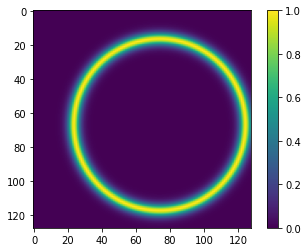

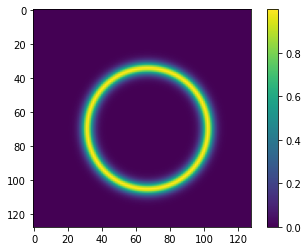

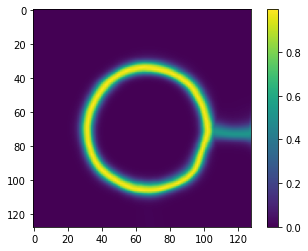

ICONLoss(all_loss=0.03414919972419739, inverse_consistency_loss=0.05272394418716431, similarity_loss=0.023604409769177437, transform_magnitude=0.005886015482246876, flips=0.0)


In [528]:
netGrad.eval()
image_A, image_B = next(iter(d1))[0], next(iter(d2))[0]
image_A = image_A.cuda()[:1]
image_B = image_B.cuda()[:1]
l_o = netGrad(image_A, image_B)
show(image_A[0, 0])

show(image_B[0, 0])
show(netGrad.warped_image_A[0, 0])
print(icon.losses.to_floats(l_o))

In [529]:
phi_AB_theta = netGrad.phi_AB_vectorfield[:1].detach()
phi_BA_theta = netGrad.phi_BA_vectorfield[:1].detach()

In [530]:
phi_AB = torch.nn.Parameter(phi_AB_theta.clone().detach())
phi_BA = torch.nn.Parameter(phi_BA_theta.clone().detach())
phi_AB_f = lambda x: netGrad.as_function(phi_AB - netGrad.identity_map)(x) + x
phi_BA_f = lambda x: netGrad.as_function(phi_BA - netGrad.identity_map)(x) + x

In [531]:
inversion_optim = torch.optim.Adam([phi_AB, phi_BA], lr=.0001)

In [532]:
for _ in range(3000):
    inversion_optim.zero_grad()
    Iepsilon = (
            netGrad.identity_map
            + torch.randn(*netGrad.identity_map.shape).to(config.device)
            * 1
            / netGrad.identity_map.shape[-1]
        )
    approx_ident = phi_AB_f(phi_BA_f(Iepsilon)) - Iepsilon
    inverse_loss = torch.mean(approx_ident**2)
    other_loss = torch.mean((phi_AB_theta - phi_AB)**2) + torch.mean((phi_BA_theta - phi_BA)**2)
    (inverse_loss + .001 * other_loss).backward()
    
    inversion_optim.step()
print(torch.sqrt(inverse_loss), "inv other", torch.sqrt(other_loss))

tensor(7.1196e-05, device='cuda:0', grad_fn=<SqrtBackward0>) inv other tensor(0.0097, device='cuda:0', grad_fn=<SqrtBackward0>)


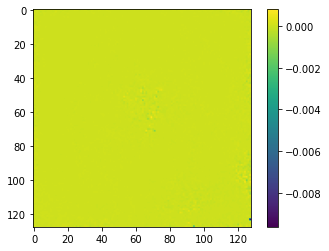

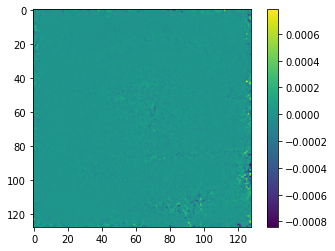

In [533]:
show(approx_ident[0, 1])
show(approx_ident[0, 0])

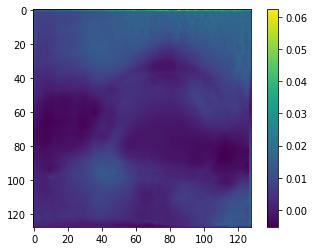

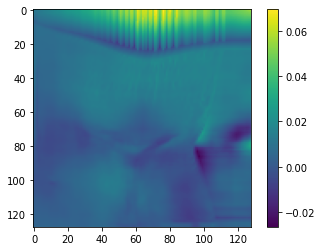

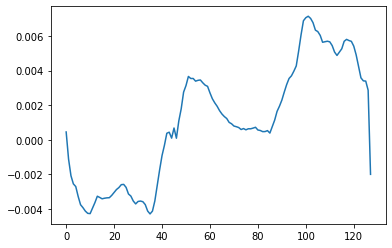

In [519]:
nAB = phi_AB_theta - phi_AB
show(nAB[0, 0])
nBA = phi_BA_theta - phi_BA
show(nBA[0, 0])
plt.plot(nAB[0, 0, 60].detach().cpu())

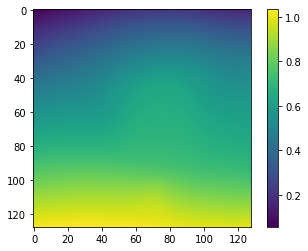

In [520]:
show(phi_AB[0, 0])

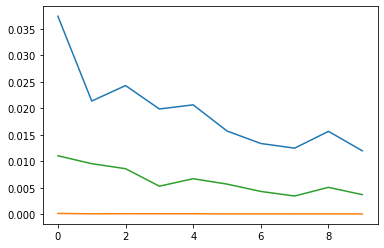

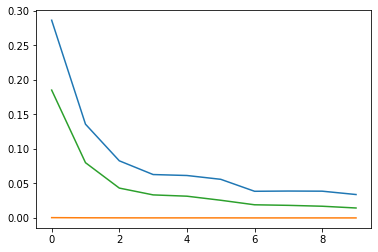

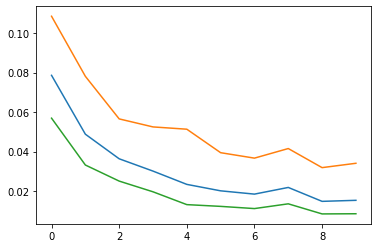

In [522]:
plt.plot(y_grad[:, :3])
plt.show()
plt.plot(y_grad2[:, :3])
plt.show()
plt.plot(y_grad3[:, :3])

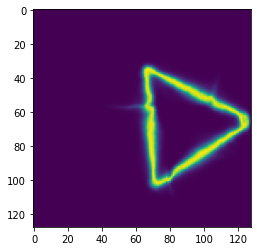

In [510]:
plt.imshow(netGrad.warped_image_A[0, 0].cpu().detach())